# Part A Convolution Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation



## Initializing Libaries

In [150]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import keras_tuner as kt
import visualkeras
from keras.regularizers import l1, l2
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential
from keras.models import Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping

## Checking GPU

In [151]:
tf.config.list_physical_devices('GPU')

[]

### Fixing random seed

In [152]:
seed = 69
np.random.seed(seed)

## factors to consider/research

- overfitting (how to prevent it)
    - data augmentation
    - L1 and L2 regulazation
    - dropout layers
    - 
- how does the various parameter of a model (dense layers, parameters of dense layers, activation fucntions, optimizers, learning rate, weigh initilzation, et...)
- affect it eg its accuracy and how does it learn/ will it have vanishing gradient / exploding gradient or any other problems?
- training time and efficiency
    - batch size
- 

## Problem statement
Our problem for this assignment is to create a deep learning model to predict vegatables using the dataset on vegatables.

We need to create 2 seperate final models to predict images on 2 different input sizes:
- 31 x 31
- 128 x128 

## Goals of this project
### Generalise to data well
> To make sure our model is able to generalise to data well, we need to __minimize__ the difference between our training accuracy and test accuracy.
### Accuracy
> In order to minimize avoidable bias, it is important for the model to achieve a training set accuracy of at least __85%__ or higher, which signifies a reasonable level of accuracy.

# Importing Datasets

In [153]:
directory_train = './datasets/Dataset for CA1 part A/train'
directory_test = './datasets/Dataset for CA1 part A/test'
directory_validation = './datasets/Dataset for CA1 part A/validation'

def dataset(directory,image_size,seed=seed,batch_size=64):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        image_size=image_size,
        shuffle=True,
        seed=seed,
        batch_size=batch_size
    )
    return dataset


In [154]:
dataset_train_31 = dataset(directory_train,(31,31))
dataset_test_31 = dataset(directory_test,(31,31))
dataset_validation_31 = dataset(directory_validation,(31,31))

dataset_train_128 = dataset(directory_train,(128,128))
dataset_test_128 = dataset(directory_test,(128,128))
dataset_validation_128 = dataset(directory_validation,(128,128))

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## EDA
What can we get from our EDA?
- How does the average image look like for each class?
- How is the class distribution?
- How does a sample image look like for each class?


In [155]:
class_labels = [
    "Bean",
    "Bitter Gourd",
    "Bottle Gourd",
    "Brinjal",
    "Broccoli",
    "Cabbage",
    "Capsicum",
    "Carrot",
    "Cauliflower",
    "Cucumber",
    "Papaya",
    "Potato",
    "Pumpkin",
    "Radish",
    "Tomato",
]

### Visualizing our datasets

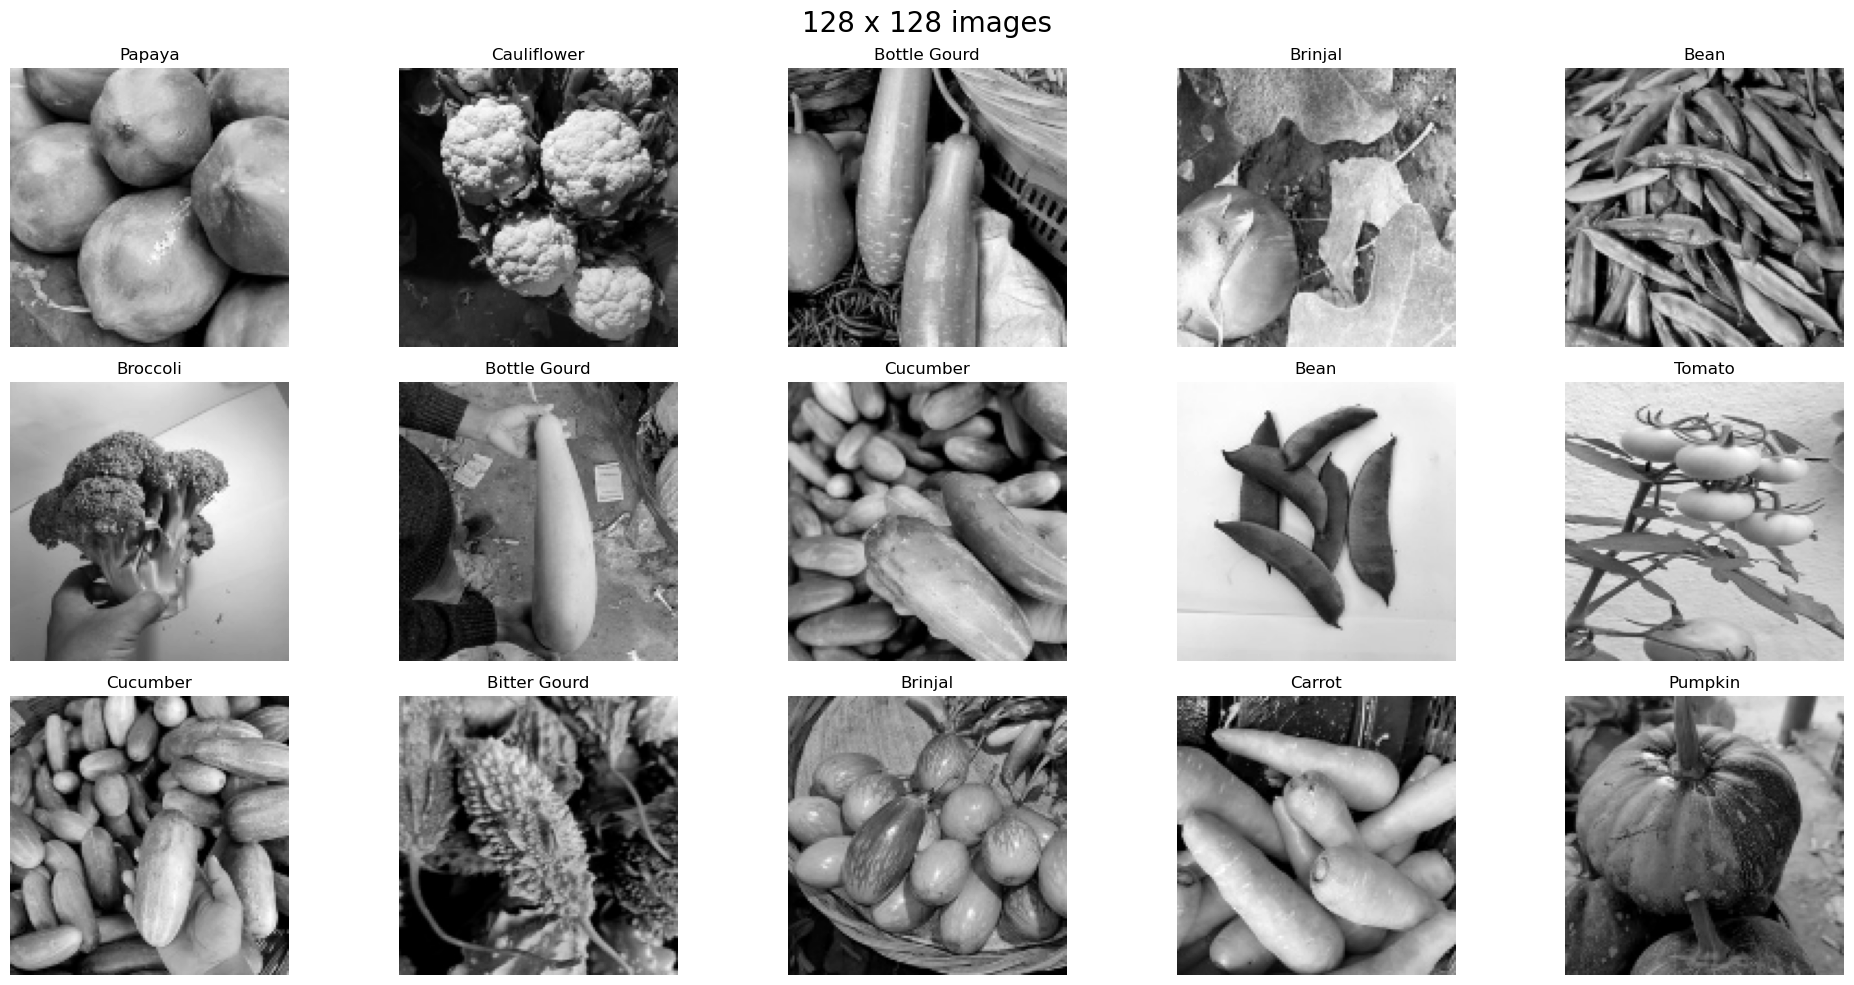

In [156]:

def plot_dataset(amtOfImages, dataset,title,class_labels):

    plt.figure(figsize=(20, 10))
    plt.suptitle(title, fontsize=20)

    for images, labels in dataset.take(1):
        num_images = len(images)  

        row = int(np.sqrt(amtOfImages))
        col = int(np.ceil(amtOfImages / row))
        
        for i in range(min(amtOfImages, num_images)):
            ax = plt.subplot(row, col, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(class_labels[np.argmax(labels[i])])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_dataset(15,dataset_train_128,'128 x 128 images',class_labels)

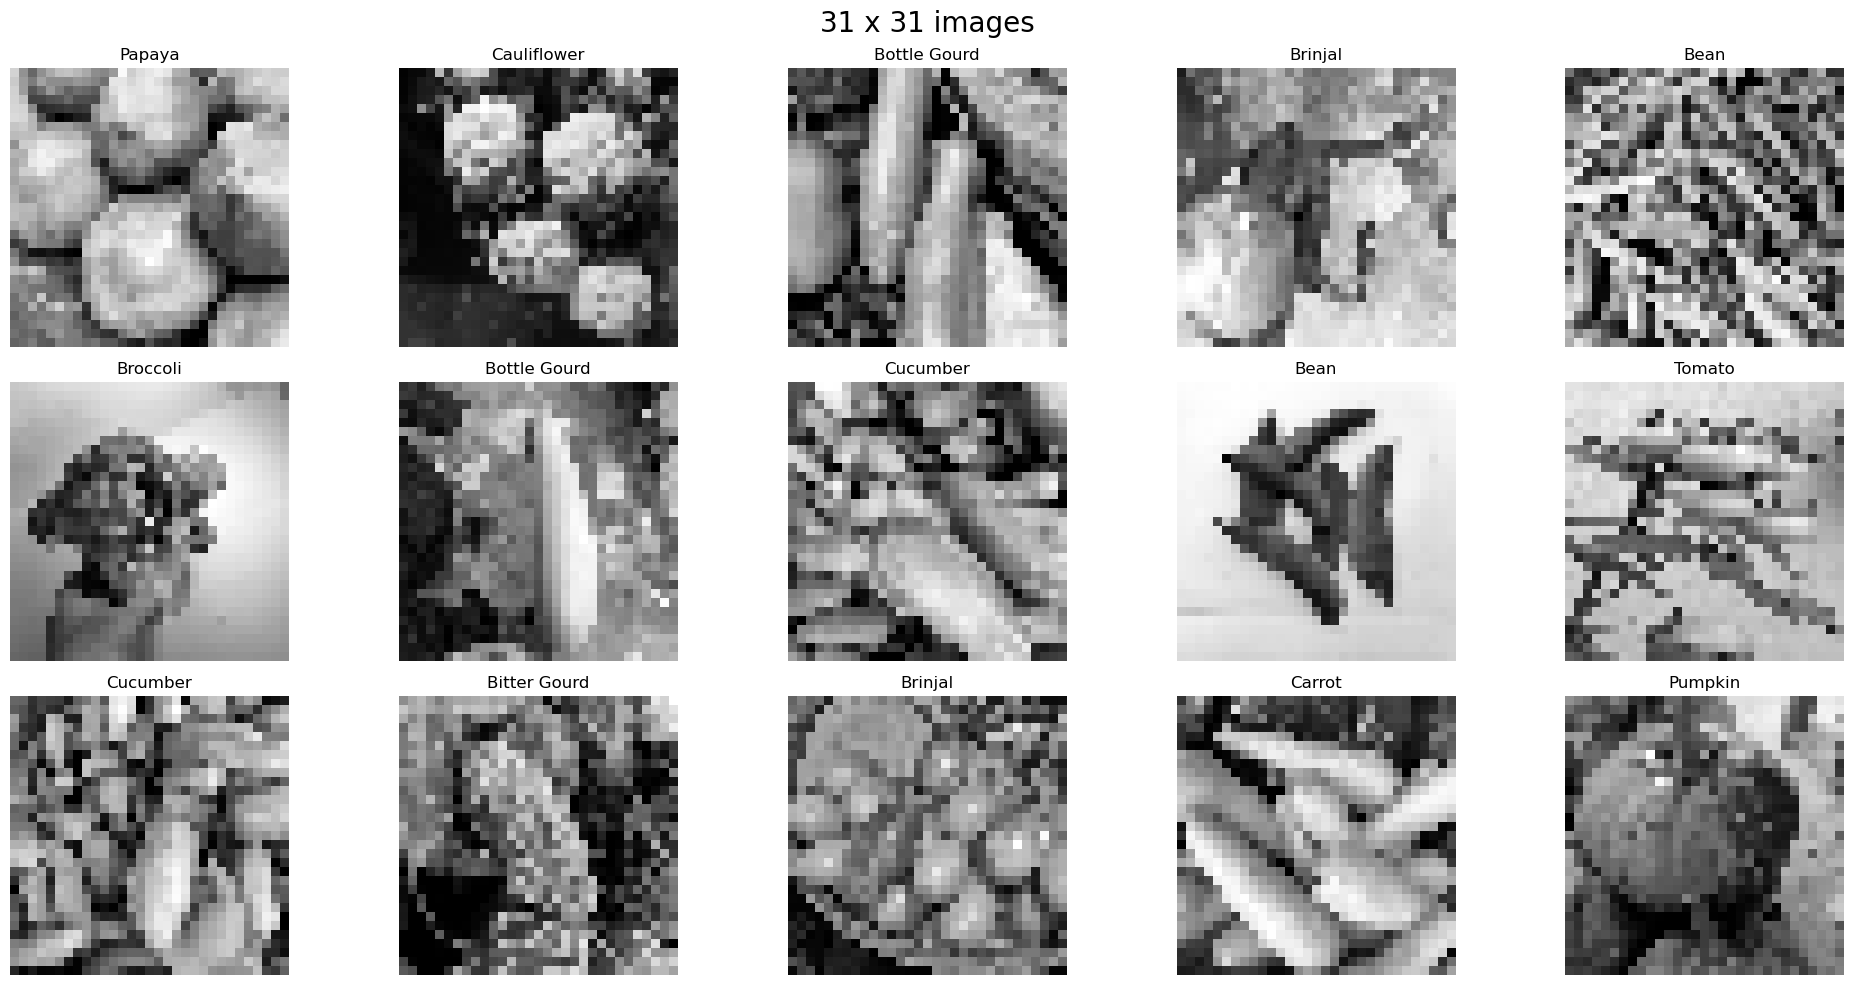

In [157]:
plot_dataset(15,dataset_train_31,'31 x 31 images',class_labels)

Observations:
- We can hardly differentiate between classes for images of size 31x31, hopefully our model can better differeniate these images better than humans!

Now lets get a wider sample range of pictures of every class, to see how diverse the classes are.

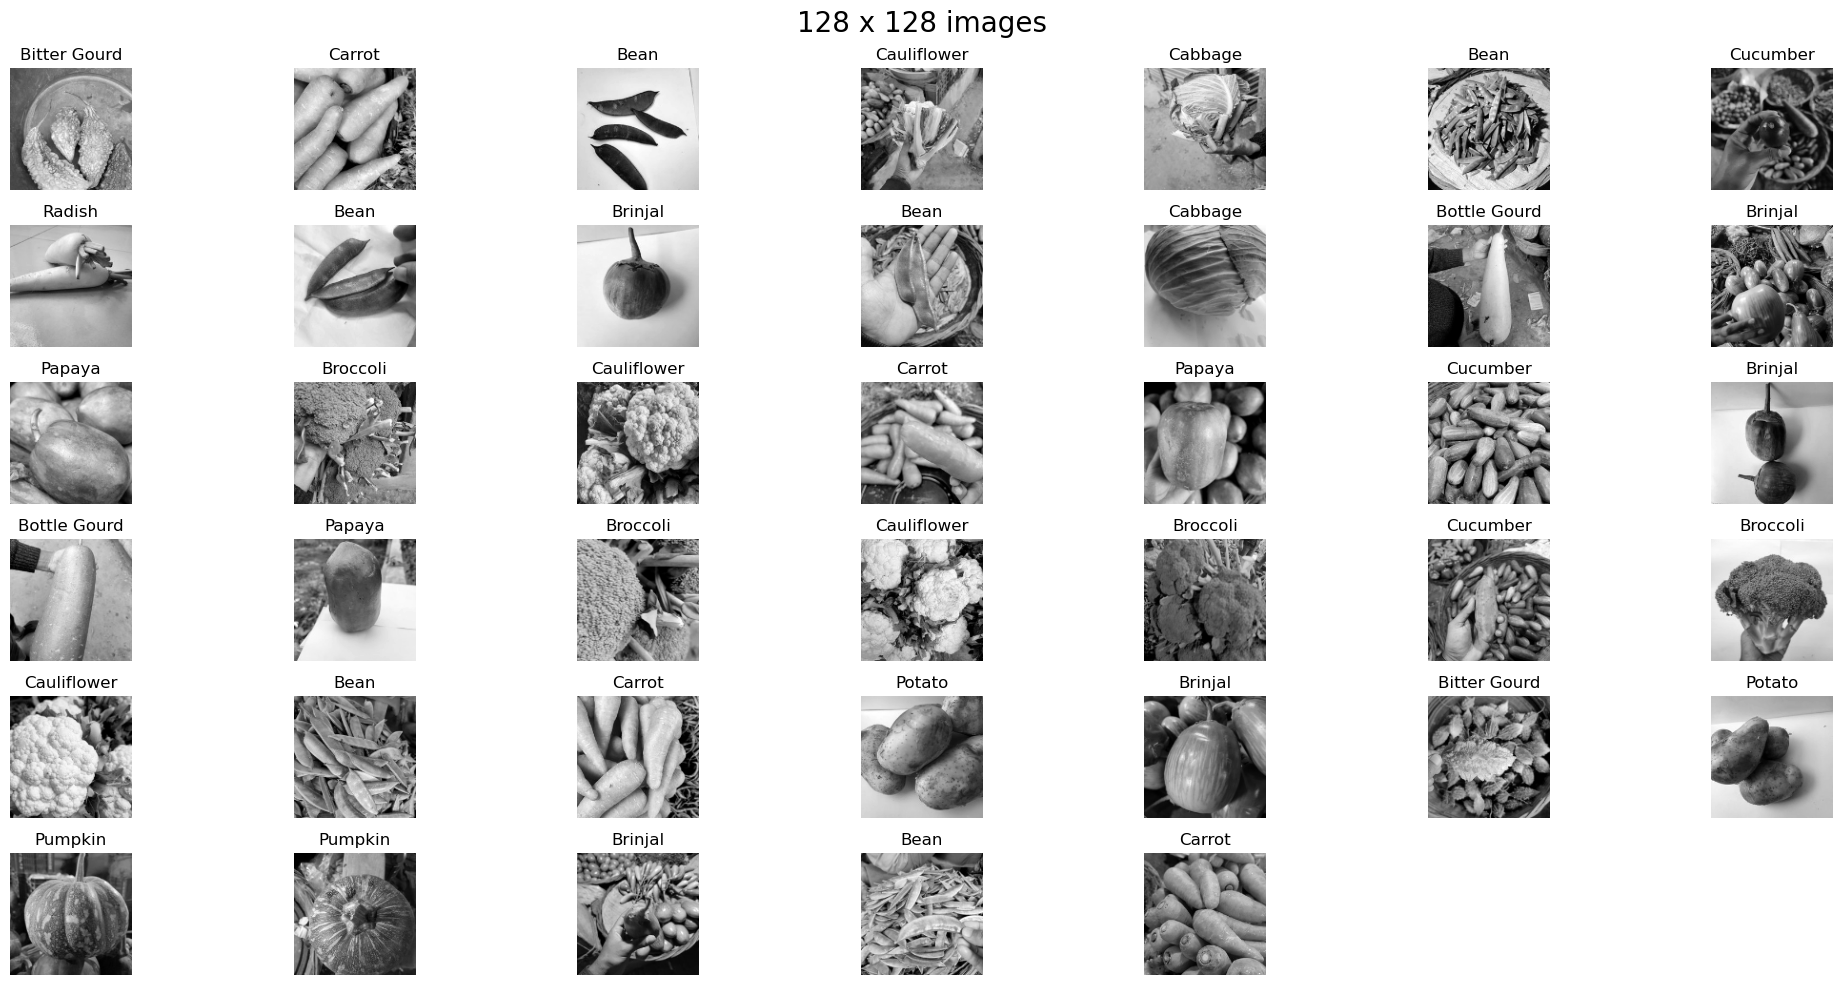

In [158]:
plot_dataset(40,dataset_test_128,'128 x 128 images',class_labels)

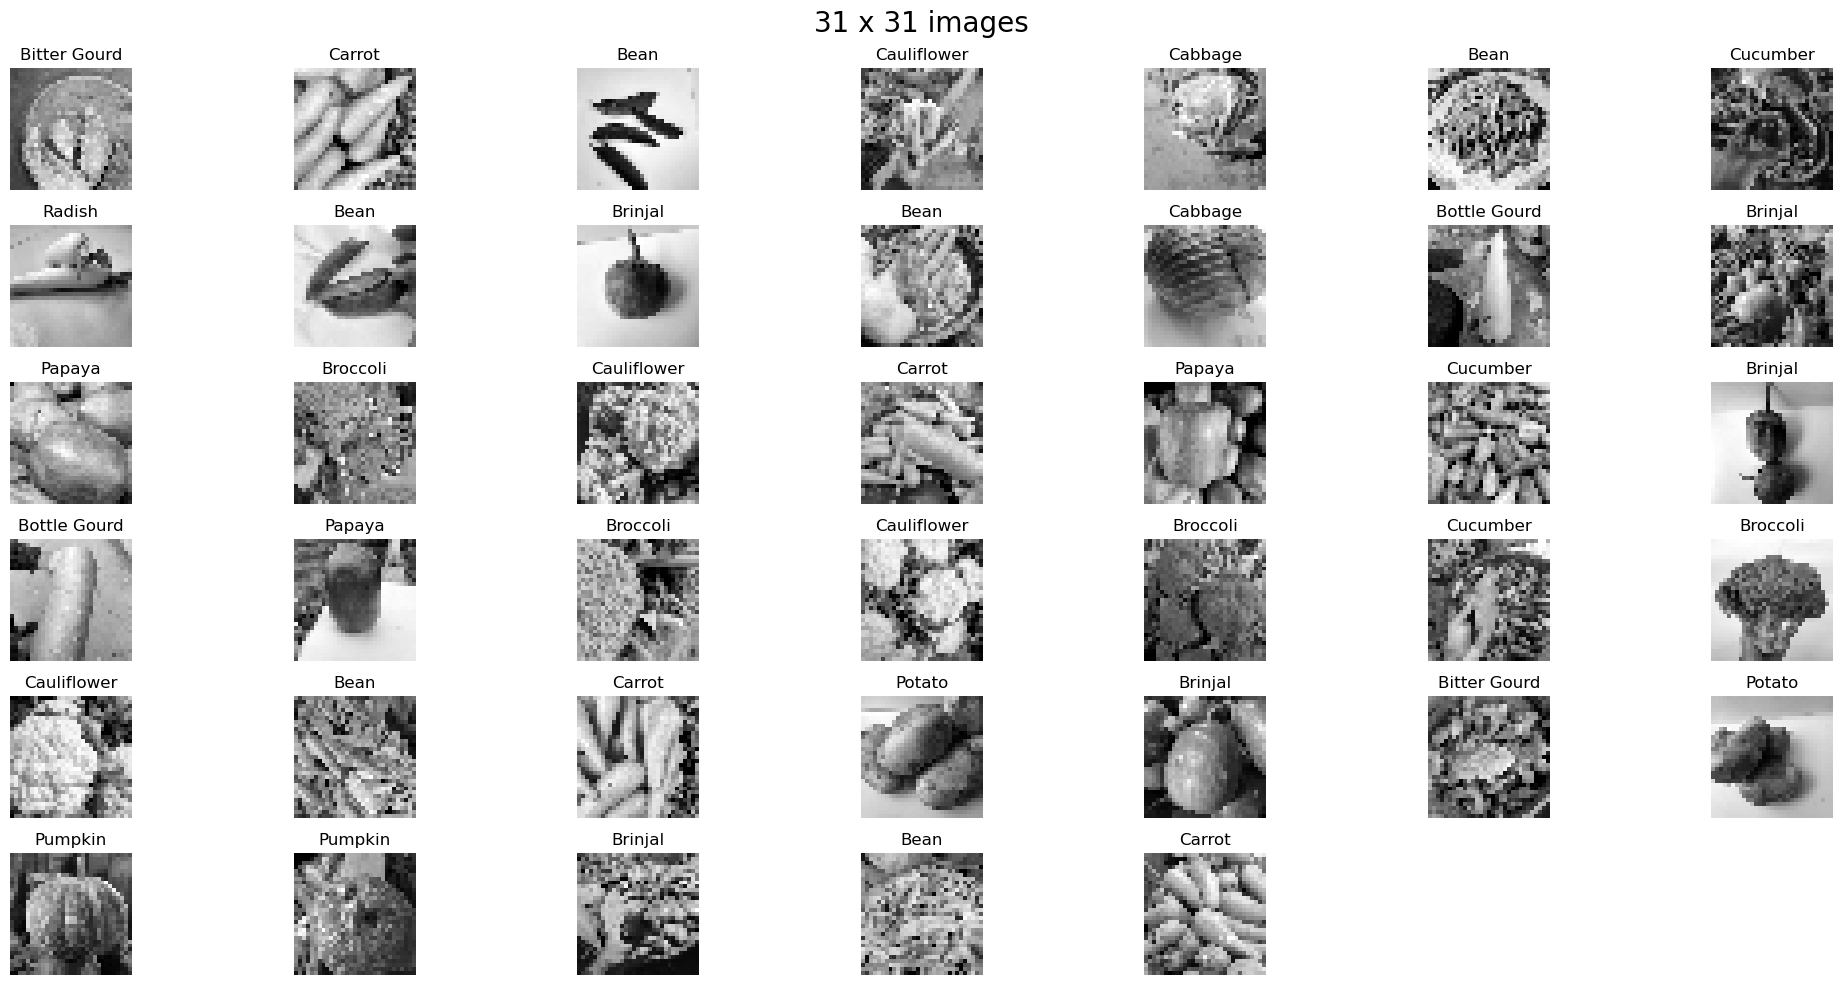

In [159]:
plot_dataset(40,dataset_test_31,'31 x 31 images',class_labels)

### Class Distribution

In [175]:
class_counts_df = pd.DataFrame(columns=class_labels)

def count_classes(dataset, class_labels):
    class_count = {label: 0 for label in class_labels}
    for _, labels in dataset:
        for label in labels:
            class_name = class_labels[tf.argmax(label)]
            class_count[class_name] += 1
    return class_count

class_counts_df.loc['Validation'] = count_classes(dataset_validation_128, class_labels)
class_counts_df.loc['Training'] = count_classes(dataset_train_128, class_labels)
class_counts_df.loc['Test'] = count_classes(dataset_test_128, class_labels)
class_counts_df.loc['Total Classes'] = class_counts_df.sum()
class_counts_df['Total Datasets'] = class_counts_df.sum(axis=1)

class_counts_df

,Bean,Bitter Gourd,Bottle Gourd,Brinjal,Broccoli,Cabbage,Capsicum,Carrot,Cauliflower,Cucumber,Papaya,Potato,Pumpkin,Radish,Tomato,Total Datasets
Validation,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Training,780,720,441,868,750,503,351,256,587,812,566,377,814,248,955,9028
Test,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Total Classes,1180,1120,841,1268,1150,903,751,656,987,1212,966,777,1214,648,1355,15028


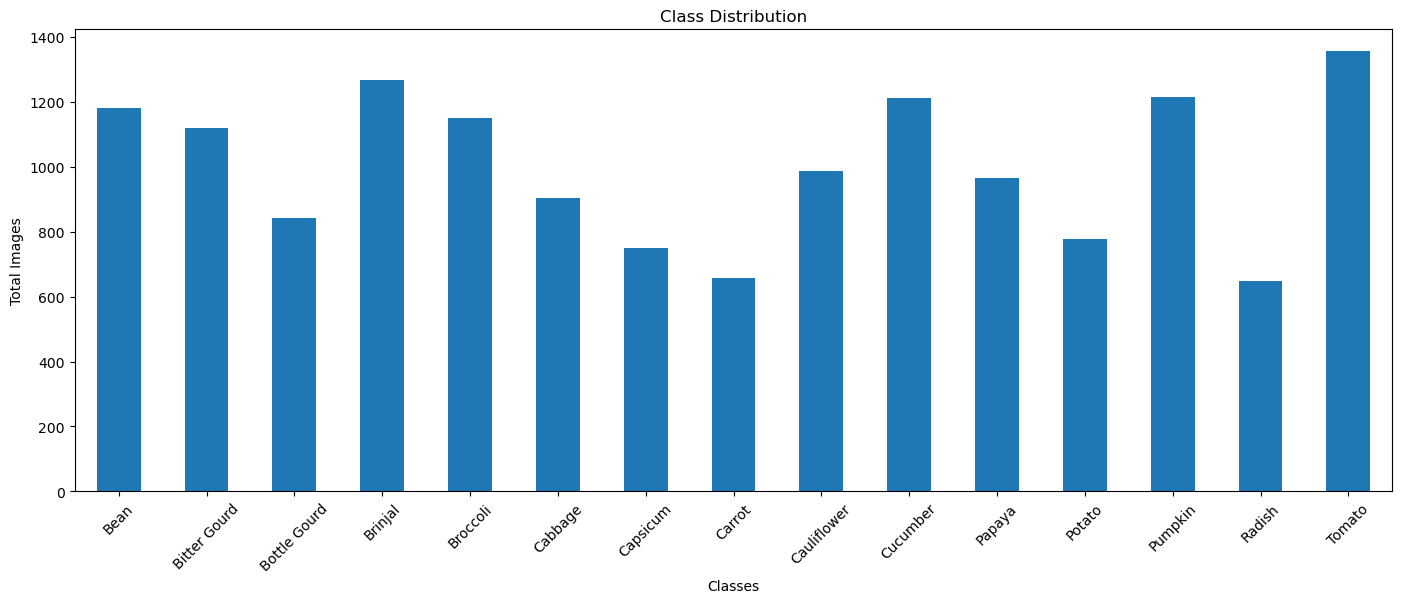

In [183]:
class_counts_df_plot = class_counts_df.drop(['Total Datasets'], axis=1)
class_counts_df_plot = class_counts_df_plot.T
class_counts_df_plot

# Plot the bar graph
class_counts_df_plot['Total Classes'].plot(kind='bar', figsize=(17, 6))
plt.xlabel('Classes')
plt.ylabel('Total Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

We can see that we have an class imbalance for our train dataset. Oh No!! What should we do?
- There are quite alot of solutions for this problem, here are 3 main solutions:
    1. We can augment our data on the minority classes(Bottle_gourd, carrots and radish). However we want to also augment our other images classes to prevent overfitting so this is not a good option.
    2. We can oversample or undersample our minority or majority classes.However oversampling can lead to overfitting without any data augmentation.
    3. We can modify the loss function to assign different weights to each class, such as increasing the loss weigh for our minority class.


We will be assigning different weights for each class for a few reasons:
- It helps preserve our data....
- Prevents overfitting....
- Much simpler than Image oversampling...

In [200]:
class_weights = tf.math.reciprocal(tf.constant(
(class_counts_df_plot['Training'].values).astype(np.float32)))

# Normalize the class weights
class_weights = class_weights / tf.reduce_sum(class_weights)

print("Class Weights:", class_weights)

Class Weights: tf.Tensor(
[0.04297926 0.04656086 0.07601774 0.03862191 0.04469843 0.06664776
 0.09550947 0.13095243 0.05711043 0.0412855  0.05922937 0.08892261
 0.04118406 0.1351767  0.03510348], shape=(15,), dtype=float32)


## Data Preprocessing

## Data Augementation


## Models
- Base
- custom model


## Hyperparemeter Tuning

## Final Model